### A coding scheme for Simon game sequences

#### **Author:** Sol Markman (smarkman@mit.edu)

Assumption: This scheme is hierarchical, so that different chunk types take priority over others. For example, repeats of a single color are chunked first, then repeats of multiple colors, then nested repeats, and then alternations are chunked with the remaining items, etc.
- RRRGRGRG is compressed to [R]3 [GR]2 G, size=6
- RRRGRG is compressed to [R]3 [GRG], size=4

#### Types of chunks/compression and their sizes:

#### 1) Repeats
Size = (size of subsequence) + 1. This assumes that size does not increase with the number of repeats, and 
repeats are only beneficial for size>2.

Single color repeats
- RRRR is compressed to [R]4, size=2

Multicolor repeats
- RGRGRG is compressed to [RG]3, size=3
    
Nested repeats
- RRRGGGRRRGGG is compressed to [ [R]3 [G]3 ]2, size=5

#### 2) Alternations
- ABA is compressed to AB*, size=2

#### 3) Cycles 
size = 3: start, length, direction (+ denotes CW, - denotes CCW)
(Y top left, B top right, G bottom right, R bottom left) 
- YBGR is compressed to Y4+ 
- YBGRY is compressed to Y5+
- GBYR = G4-

#### 4) Exposure compression (within a sequence)
Not yet implemented


In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec

from common_methods import *

In [2]:
# testing simple repeat scheme
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                    'BBBBBBBrrrBBBBBB', 'GGGGGGGG', 'ABCD', 'BGGGR', 'abbabbabba']
answers = [8, 7, 5, 8, 5, 6, 2, 4, 4, 10]
print('Simple repeat scheme test:')
test_coding_scheme(simple_repeat_scheme, test_sequences, answers)

Simple repeat scheme test:
BBBRRRYYYGGG 8
[B]3[R]3[Y]3[G]3 8
RRRZGZRRR 7
[R]3ZGZ[R]3 7
BBBBGRY 5
[B]4GRY 5
RRRYGYGYG 8
[R]3YGYGYG 8
GBGBB 5
GBG[B]2 5
BBBBBBBrrrBBBBBB 6
[B]7[r]3[B]6 6
GGGGGGGG 2
[G]8 2
ABCD 4
ABCD 4
BGGGR 4
B[G]3R 4
abbabbabba 10
a[b]2a[b]2a[b]2a 10


In [ ]:
# testing complex repeat scheme
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                'BBBBBBBrrrBBBBBB', 'GRGRGRZDZDZDZTTTTTTTGGG', 'ababcdcdababcdcd',
                'abbabbabba', 'abcabcabc', 'abbccccabbccccabbcccc', 'bbbbaaaabbbbaaaa',
                'bbbaaabbbaaa', 'bbaabbaa', 'baba', 'bbaabbaab']
answers = [8, 7, 5, 5, 5, 6, 11, 7, 5, 4, 6, 5, 5, 5, 3, 6]
print('\nComplex repeat scheme test:')
test_coding_scheme(complex_repeat_scheme, test_sequences, answers)

In [6]:
# testing repeats alternations scheme
test_sequences = ['BBBRYRGYG', 'BRBRBGTG', 'ABACBCDEDFGF']
answers = [6, 6, 8]

test_coding_scheme(repeat_alternation_scheme, test_sequences, answers)

BBBRYRGYG 6
[B]3[RY*][GY*] 6
BRBRBGTG 6
[BR]2B[GT*] 6
ABACBCDEDFGF 8
[AB*][CB*][DE*][FG*] 8


In [10]:
# testing cycles repeats alternations scheme
weight_dirs = 0.5
test_sequences = ['YBGRYBGRt', 'GBYRBGRYB', 'YBGRY', 'YYYYYBGRY', 'BBBBBBBGBYRYR', 'YBGRRGBYYBGR']
answers = [3 + weight_dirs, 4 + 2*weight_dirs, 2 + weight_dirs, 4 + weight_dirs, 6 + weight_dirs, 6 + 3*weight_dirs] # repeats chunked first
test_coding_scheme(lambda x: cycle_rep_alt_scheme(x, weight_dirs), test_sequences, answers)

YBGRYBGRt 3.5
[Y8+]t 3.5
GBYRBGRYB 5.0
[G4-][B5+] 5.0
YBGRY 2.5
[Y5+] 2.5
YYYYYBGRY 4.5
[Y]4[Y5+] 4.5
BBBBBBBGBYRYR 6.5
[B]7[G4-]YR 6.5
YBGRRGBYYBGR 7.5
[Y4+][R4-][Y4+] 7.5


In [11]:
# Methods for analysis

def get_code_lengths(scheme, seq):
    return scheme(seq)[0]

def get_chunkability_simple(scheme, seq):

    l = get_code_lengths(scheme, seq)
    chunkability = 1 - l/len(seq)
    return chunkability

def get_chunkability_percentile(scheme, seq, n_samples=1000):

    cl_samples = sample_compressed_lengths(scheme, len(seq), n_samples)
    cl_datapt = get_code_lengths(scheme, seq)
    cl_percentile = stats.percentileofscore(cl_samples, cl_datapt, kind='mean')
    chunkability = (50 - cl_percentile) # should positive if the compression length is less than the median

    return chunkability

def get_chunkabilities_from_logs(data_path, 
                get_chunkability=get_chunkability_percentile, weight_dirs=0.5):
    
    session_data = parse_simons_game_logs(data_path)
    N_games = 0
    scores = []
    sequences = []

    for i, key in enumerate(session_data.keys()):
        N_games += len(session_data[key])
        for game in session_data[key].values():
            sequences.append(game['longest_sequence'])
            scores.append(len(game['longest_sequence']))
            
    # Compute chunkabilities for each sequence
    simple_rep = []
    LZ = []
    complex_rep = []
    rep_alt = []
    cycle_ra = []
    for seq in sequences:
        simple_rep.append(get_chunkability(simple_repeat_scheme, seq))
        LZ.append(get_chunkability(LZ_scheme, seq))
        complex_rep.append(get_chunkability(complex_repeat_scheme, seq))
        rep_alt.append(get_chunkability(repeat_alternation_scheme, seq))
        cycle_ra.append(get_chunkability(lambda x: cycle_rep_alt_scheme(x, weight_dirs), seq))

    results = dict(scores=scores, sequences=sequences, simple_repeats=simple_rep, 
                   LZ_complexity=LZ, complex_repeats=complex_rep, 
                   repeat_alternation=rep_alt, cycle_rep_alt=cycle_ra)
    return results

def get_measure_multiple_seqs(scheme, random_sequences, get_measure=get_code_lengths):
    
    measures = []
    for i in range(len(random_sequences)):
        seq = random_sequences[i]
        measures.append(get_measure(scheme, seq))
        
    return np.array(measures)

# games:  18
Hyp:   slope,   intercept,   r-value,   p-value,   std_err
Hyp1:  2.1313789715034392 -33.820627251883394 0.5279924315228708 0.024307632369184977 0.8570537724802196
Hyp2:  1.6269489027186372 -12.45058958401572 0.35932224876495966 0.14306630614029525 1.0563573220868803
Hyp3:  1.2613331149688833 -8.628848673435968 0.2743248764771391 0.2706307897082958 1.105390715590844
Hyp4:  1.550188339338356 -14.280519161480518 0.31978790667371376 0.19579235986260057 1.1482506105815073
Hyp5:  2.262700622338683 -37.17653128070749 0.48276995386346594 0.04242742998509977 1.026137674800171


Text(0.5, 0.98, 'For logs in ./Jack_logs')

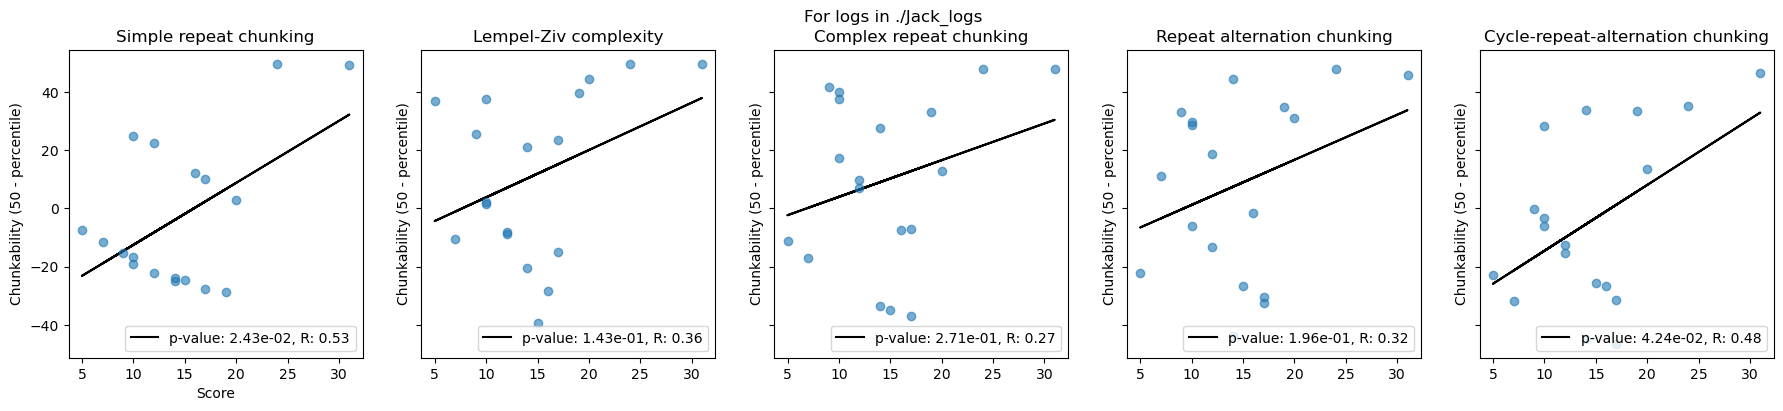

In [14]:
# Within-subjects analysis

np.random.seed(1234)
data_path = './Jack_logs' #'./Trautman_logs' #'./Sol_logs/Random' #  './Quilee_logs' # './Hokyung_logs' #
chunk_dict = get_chunkabilities_from_logs(data_path, weight_dirs=0.5)
scores = chunk_dict['scores']
chunk1 = chunk_dict['simple_repeats']
chunk2 = chunk_dict['LZ_complexity']
chunk3 = chunk_dict['complex_repeats']
chunk4 = chunk_dict['repeat_alternation']
chunk5 = chunk_dict['cycle_rep_alt']

print('# games: ', len(scores))

ylabel = 'Chunkability'

m1, b1, r1, p1, std_err1 = stats.linregress(scores, chunk1)
m2, b2, r2, p2, std_err2 = stats.linregress(scores, chunk2)
m3, b3, r3, p3, std_err3 = stats.linregress(scores, chunk3)
m4, b4, r4, p4, std_err4 = stats.linregress(scores, chunk4)
m5, b5, r5, p5, std_err5 = stats.linregress(scores, chunk5)

print('Hyp:   slope,   intercept,   r-value,   p-value,   std_err')
print('Hyp1: ', m1, b1, r1, p1, std_err1)
print('Hyp2: ', m2, b2, r2, p2, std_err2)
print('Hyp3: ', m3, b3, r3, p3, std_err3)
print('Hyp4: ', m4, b4, r4, p4, std_err4)
print('Hyp5: ', m5, b5, r5, p5, std_err5)

fig, ax = plt.subplots(1, 5, figsize=(22, 4), sharex=False, sharey=True)

ax[0].scatter(scores, chunk1, alpha=0.6)
ax[1].scatter(scores, chunk2, alpha=0.6)
ax[2].scatter(scores, chunk3, alpha=0.6)
ax[3].scatter(scores, chunk4, alpha=0.6)
ax[4].scatter(scores, chunk5, alpha=0.6)
ax[0].set(ylabel=ylabel, xlabel='Score', title='Simple repeat chunking')
ax[1].set(ylabel=ylabel, title='Lempel-Ziv complexity')
ax[2].set(ylabel=ylabel, title='Complex repeat chunking')
ax[3].set(ylabel=ylabel, title='Repeat alternation chunking')
ax[4].set(ylabel=ylabel, title='Cycle-repeat-alternation chunking')

ax[0].plot(np.array(scores), m1*np.array(scores) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.2e}, R: {r1:.2f}')
ax[1].plot(np.array(scores), m2*np.array(scores) + b2, color='k', zorder=0, 
           label=f'p-value: {p2:.2e}, R: {r2:.2f}')
ax[2].plot(np.array(scores), m3*np.array(scores) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.2e}, R: {r3:.2f}')
ax[3].plot(np.array(scores), m4*np.array(scores) + b4, color='k', zorder=0, 
           label=f'p-value: {p4:.2e}, R: {r4:.2f}')
ax[4].plot(np.array(scores), m5*np.array(scores) + b5, color='k', zorder=0,
            label=f'p-value: {p5:.2e}, R: {r5:.2f}')

ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
ax[4].legend(loc='lower right')

fig.suptitle(f'For logs in {data_path}')

['./Hokyung_logs', './Jack_logs', './Quilee_logs', './Sol_logs/Random', './Trautman_logs']
Hyp:   slope,   intercept,   r-value,   p-value,   std_err
Hyp1:  3.2228899159663875 -0.9773388846447704 0.3872445466504979 0.09163125868456608 1.808606195216408
Hyp2:  1.1660276865291574 3.3713611153552305 0.11227841108943976 0.6374351841134636 2.4323244015449994
Hyp3:  5.344523491214668 -1.400456518971228 0.44896806537947603 0.04706253009680066 2.5071197489221513
Hyp4:  6.485392201426025 -2.484112095747393 0.5059409156054838 0.022845965441358102 2.606115151631427
Hyp5:  8.61446705500382 -8.06723943213649 0.6001191690374345 0.00515173741224601 2.7064257670604936
TtestResult(statistic=-1.275299995563769, pvalue=0.2712364960067458, df=4)
TtestResult(statistic=-0.5766518205091979, pvalue=0.5950710993160498, df=4)
TtestResult(statistic=-2.0719436322197993, pvalue=0.10699433540563978, df=4)
TtestResult(statistic=-2.2775682974131946, pvalue=0.0850143356970802, df=4)
TtestResult(statistic=-3.8640810121

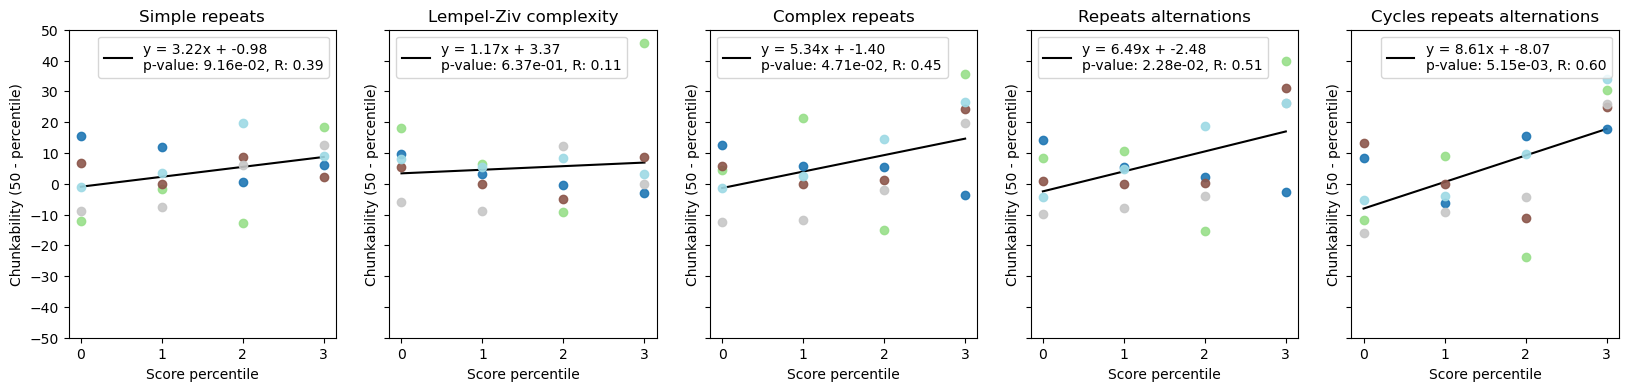

In [33]:
# Combining data across subjects
# This approach tries to account for the different number of games
# and the different distributions of scores for each subject by computing a 
# within-subject score percentile, only including subjects with scores in each 
# pre-defined score percentile bin (e.g. [0, 25, 50, 75, 100]),
# and then computing the average chunkability for each bin.
# So each subject contributes one data point to each bin.

np.random.seed(1234)
data_paths_ = ['./Ajani_logs', './Annesya_logs', './Gershman_logs', './Hokyung_logs',
               './Jack_logs', './Mahdi_logs', './Mel_logs', './Nathan_logs', 
               './Nick_logs', './Quilee_logs', './Sagarika_logs', './Sol_logs/Random', 
               './Trautman_logs', './Vin_logs']

N_subjects = len(data_paths_)
N_games = np.zeros(N_subjects, dtype=int)
median_scores = np.zeros(N_subjects, dtype=int)

pbins = [-1, 25, 50, 75, 101] #[-1, 33, 67, 101] #[-1, 50, 101] #
all_chunk1_avgs = []
all_chunk2_avgs = []
all_chunk3_avgs = []
all_chunk4_avgs = []
all_chunk5_avgs = []
dat_inds = []
N_quants = len(pbins) - 1
min_per_bin = 3

for i, data_path in enumerate(data_paths_):

    chunk_dict = get_chunkabilities_from_logs(data_path)
    scores = chunk_dict['scores']
    chunk1 = chunk_dict['simple_repeats']
    chunk2 = chunk_dict['LZ_complexity']
    chunk3 = chunk_dict['complex_repeats']
    chunk4 = chunk_dict['repeat_alternation']
    chunk5 = chunk_dict['cycle_rep_alt']
    N_games[i] = len(scores)

    if N_games[i] < N_quants*min_per_bin:
        continue

    median_scores[i] = np.median(scores)
    score_percentiles = np.array([stats.percentileofscore(scores, i, kind='mean') for i in scores])
    score_quantiles = np.digitize(score_percentiles, pbins)

    if np.unique(score_quantiles).size < N_quants:
        continue
    
    dat_inds.append(i)
    chunk1_avg = np.zeros(N_quants)
    chunk2_avg = np.zeros(N_quants)
    chunk3_avg = np.zeros(N_quants)
    chunk4_avg = np.zeros(N_quants)
    chunk5_avg = np.zeros(N_quants)
    for j in range(N_quants):

        idx = np.where(score_quantiles == j+1)[0]
        if idx.shape[0] < min_per_bin:
            continue
        chunk1_avg[j] = np.mean(np.array(chunk1)[idx])
        chunk2_avg[j] = np.mean(np.array(chunk2)[idx])
        chunk3_avg[j] = np.mean(np.array(chunk3)[idx])
        chunk4_avg[j] = np.mean(np.array(chunk4)[idx])
        chunk5_avg[j] = np.mean(np.array(chunk5)[idx])
    
    all_chunk1_avgs.append(chunk1_avg)
    all_chunk2_avgs.append(chunk2_avg)
    all_chunk3_avgs.append(chunk3_avg)
    all_chunk4_avgs.append(chunk4_avg)
    all_chunk5_avgs.append(chunk5_avg)

all_chunk1_avgs = np.array(all_chunk1_avgs)
all_chunk2_avgs = np.array(all_chunk2_avgs)
all_chunk3_avgs = np.array(all_chunk3_avgs)
all_chunk4_avgs = np.array(all_chunk4_avgs)
all_chunk5_avgs = np.array(all_chunk5_avgs)

['./Hokyung_logs', './Jack_logs', './Quilee_logs', './Sol_logs/Random', './Trautman_logs']


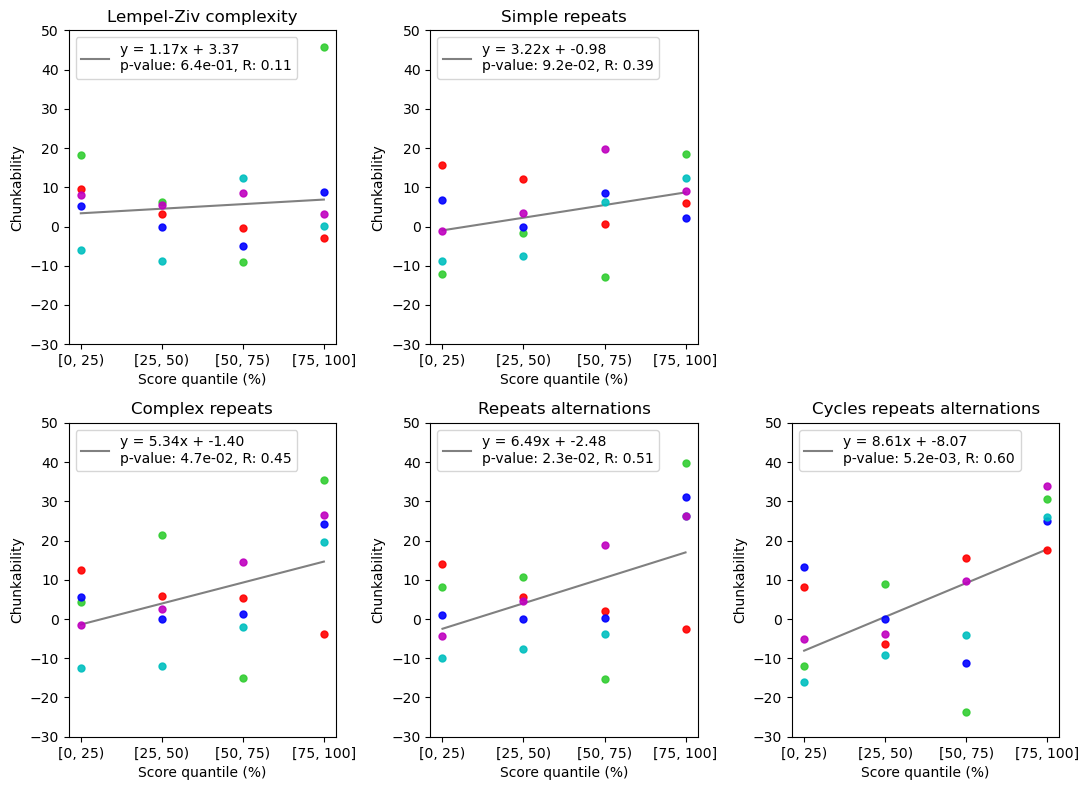

In [79]:
# Plot
colors = ['r', 'limegreen', 'b', 'c', 'm']
alpha = 0.9
s = 25
#fig, ax = plt.subplots(1, 5, figsize=(22, 6), sharex=True, sharey=True)
fig = plt.figure(figsize=(11, 8))
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

print([data_paths_[i] for i in dat_inds])
x = np.arange(N_quants)
for i in range(len(dat_inds)):
    ax2.scatter(x, all_chunk1_avgs[i], alpha=alpha, color=colors[i], s=s)
    ax1.scatter(x, all_chunk2_avgs[i], alpha=alpha, color=colors[i], s=s)
    ax3.scatter(x, all_chunk3_avgs[i], alpha=alpha, color=colors[i], s=s)
    ax4.scatter(x, all_chunk4_avgs[i], alpha=alpha, color=colors[i], s=s)
    ax5.scatter(x, all_chunk5_avgs[i], alpha=alpha, color=colors[i], s=s)

x_reg = np.tile(x, (all_chunk1_avgs.shape[0]))
m1, b1, r1, p1, std_err1 = stats.linregress(x_reg, all_chunk1_avgs.flatten())
m2, b2, r2, p2, std_err2 = stats.linregress(x_reg, all_chunk2_avgs.flatten())
m3, b3, r3, p3, std_err3 = stats.linregress(x_reg, all_chunk3_avgs.flatten())
m4, b4, r4, p4, std_err4 = stats.linregress(x_reg, all_chunk4_avgs.flatten())
m5, b5, r5, p5, std_err5 = stats.linregress(x_reg, all_chunk5_avgs.flatten())

lc = 'grey'
ax2.plot(x, m1*x + b1, color=lc, zorder=0, 
           label=f'y = {m1:.2f}x + {b1:.2f}\np-value: {p1:.1e}, R: {r1:.2f}')
ax1.plot(x, m2*x + b2, color=lc, zorder=0, 
            label=f'y = {m2:.2f}x + {b2:.2f}\np-value: {p2:.1e}, R: {r2:.2f}')
ax3.plot(x, m3*x + b3, color=lc, zorder=0, 
            label=f'y = {m3:.2f}x + {b3:.2f}\np-value: {p3:.1e}, R: {r3:.2f}')
ax4.plot(x, m4*x + b4, color=lc, zorder=0, 
            label=f'y = {m4:.2f}x + {b4:.2f}\np-value: {p4:.1e}, R: {r4:.2f}')
ax5.plot(x, m5*x + b5, color=lc, zorder=0, 
            label=f'y = {m5:.2f}x + {b5:.2f}\np-value: {p5:.1e}, R: {r5:.2f}')

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.set(xlabel='Score quantile (%)', ylabel='Chunkability',
              title=['Lempel-Ziv complexity', 'Simple repeats', 'Complex repeats', 
                     'Repeats alternations', 'Cycles repeats alternations'][i])
    ax.set_yticks(np.arange(-30, 51, 10))
    ax.set_xticks(x)
    ax.set_xticklabels(['[0, 25)', '[25, 50)', '[50, 75)', '[75, 100]'])
    ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('./Simon_allsubs_analysis.png', dpi=500)


In [ ]:
# Combining data across subjects
# This approach is not ideal because the number of games played by each subject is different
# and each subject may have a different distribution of scores

np.random.seed(1234)
data_paths_ = ['./Ajani_logs', './Annesya_logs', './Gershman_logs', './Hokyung_logs',
               './Jack_logs', './Mahdi_logs', './Mel_logs', './Nathan_logs', 
               './Nick_logs', './Quilee_logs', './Sagarika_logs', './Sol_logs/Random', 
               './Trautman_logs', './Vin_logs']

N_subjects = len(data_paths_)
min_games = 5
N_games = np.zeros(N_subjects, dtype=int)
all_scores = []
all_chunk1 = []
all_chunk2 = []
all_chunk3 = []
all_chunk4 = []
all_chunk5 = []

colors = plt.cm.tab20(np.linspace(0, 1, N_subjects))
alpha = 0.4
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=False, sharey=True)

for i, data_path in enumerate(data_paths_):

    chunk_dict = get_chunkabilities_from_logs(data_path)
    scores = chunk_dict['scores']
    chunk1 = chunk_dict['simple_repeats']
    chunk2 = chunk_dict['LZ_complexity']
    chunk3 = chunk_dict['complex_repeats']
    chunk4 = chunk_dict['repeat_alternation']
    chunk5 = chunk_dict['cycle_rep_alt']
    
    N_games[i] = len(scores)

    if N_games[i] < min_games:
        continue
    
    all_scores.extend(scores)
    all_chunk1.extend(chunk1)
    all_chunk2.extend(chunk2)
    all_chunk3.extend(chunk3)

    ax[0].scatter(scores, chunk1, alpha=alpha, color=colors[i])
    ax[1].scatter(scores, chunk3, alpha=alpha, color=colors[i])
    ax[2].scatter(scores, chunk2, alpha=alpha, color=colors[i])


ylabel = 'Chunkability (50 - percentile)'
ax[0].set(ylabel=ylabel, xlabel='Score', title='Simple repeat chunking')
ax[1].set(ylabel=ylabel, xlabel='Score', title='Complex repeat chunking')
ax[2].set(ylabel=ylabel, xlabel='Score', title='Lempel-Ziv complexity')

m1, b1, r1, p1, std_err1 = stats.linregress(all_scores, all_chunk1)
m2, b2, r2, p2, std_err2 = stats.linregress(all_scores, all_chunk2)
m3, b3, r3, p3, std_err3 = stats.linregress(all_scores, all_chunk3)

print('Hyp:   slope,   intercept,   r-value,   p-value,   std_err')
print('Hyp1: ', m1, b1, r1, p1, std_err1)
print('Hyp3: ', m3, b3, r3, p3, std_err3)

ax[0].plot(np.array(all_scores), m1*np.array(all_scores) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.2e}, R: {r1:.2f}')
ax[1].plot(np.array(all_scores), m3*np.array(all_scores) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.2e}, R: {r3:.2f}')
ax[2].plot(np.array(all_scores), m2*np.array(all_scores) + b2, color='k', zorder=0,
              label=f'p-value: {p2:.2e}, R: {r2:.2f}')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')

print(N_games)

Text(0.5, 0.98, 'Simulated random data')

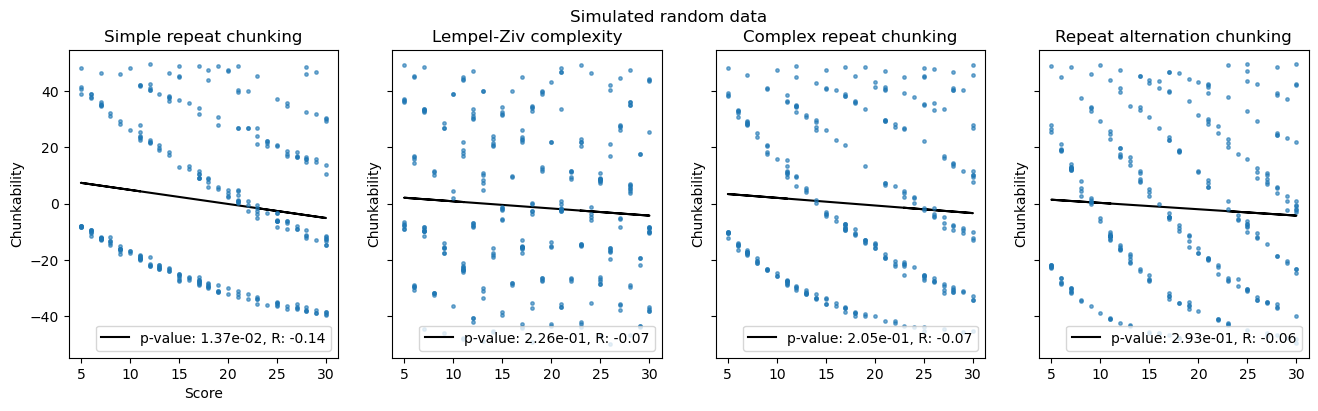

In [14]:
# Check that randomly simulated data yields no chunkability correlation

# Calculate measures for random sequences

np.random.seed(128)
random_seqs = sample_random_sequences(30, 300, min=5)
lengths = np.array([len(seq) for seq in random_seqs])

measure = get_chunkability_percentile
c1 = get_measure_multiple_seqs(simple_repeat_scheme, random_seqs, measure)
c2 = get_measure_multiple_seqs(LZ_scheme, random_seqs, measure)
c3 = get_measure_multiple_seqs(complex_repeat_scheme, random_seqs, measure)
c4 = get_measure_multiple_seqs(repeat_alternation_scheme, random_seqs, measure)

m1, b1, r1, p1, std_err1 = stats.linregress(lengths, c1)
m2, b2, r2, p2, std_err2 = stats.linregress(lengths, c2)
m3, b3, r3, p3, std_err3 = stats.linregress(lengths, c3)
m4, b4, r4, p4, std_err4 = stats.linregress(lengths, c4)

s = 6
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=False, sharey=True)
ax[0].scatter(lengths, c1, alpha=0.6, s=s)
ax[1].scatter(lengths, c2, alpha=0.6, s=s)
ax[2].scatter(lengths, c3, alpha=0.6, s=s)
ax[3].scatter(lengths, c4, alpha=0.6, s=s)
ax[0].set(ylabel='Chunkability', xlabel='Score', title='Simple repeat chunking')
ax[1].set(ylabel='Chunkability', title='Lempel-Ziv complexity')
ax[2].set(ylabel='Chunkability', title='Complex repeat chunking')
ax[3].set(ylabel='Chunkability', title='Repeat alternation chunking')
ax[0].plot(np.array(lengths), m1*np.array(lengths) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.2e}, R: {r1:.2f}')
ax[1].plot(np.array(lengths), m2*np.array(lengths) + b2, color='k', zorder=0,
              label=f'p-value: {p2:.2e}, R: {r2:.2f}')
ax[2].plot(np.array(lengths), m3*np.array(lengths) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.2e}, R: {r3:.2f}')
ax[3].plot(np.array(lengths), m4*np.array(lengths) + b4, color='k', zorder=0,
            label=f'p-value: {p4:.2e}, R: {r4:.2f}')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
fig.suptitle(f'Simulated random data')

[Text(0.5, 0, 'Sequence length'),
 Text(0, 0.5, 'Code length'),
 Text(0.5, 1.0, 'Lempel-Ziv complexity')]

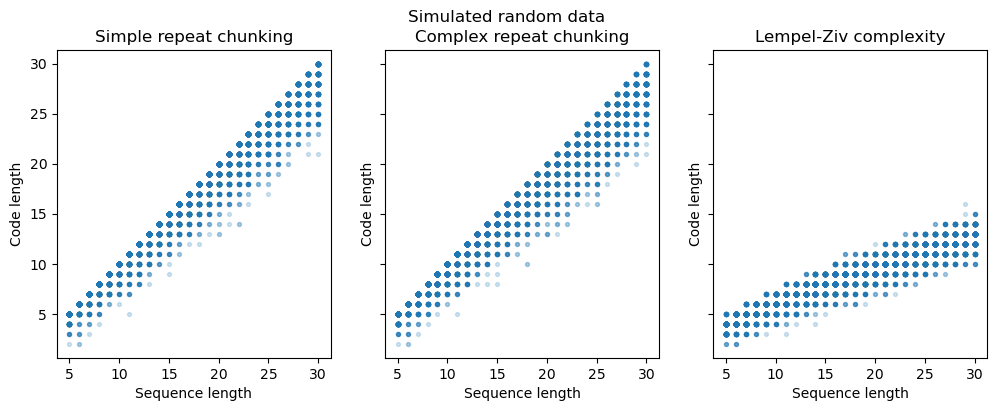

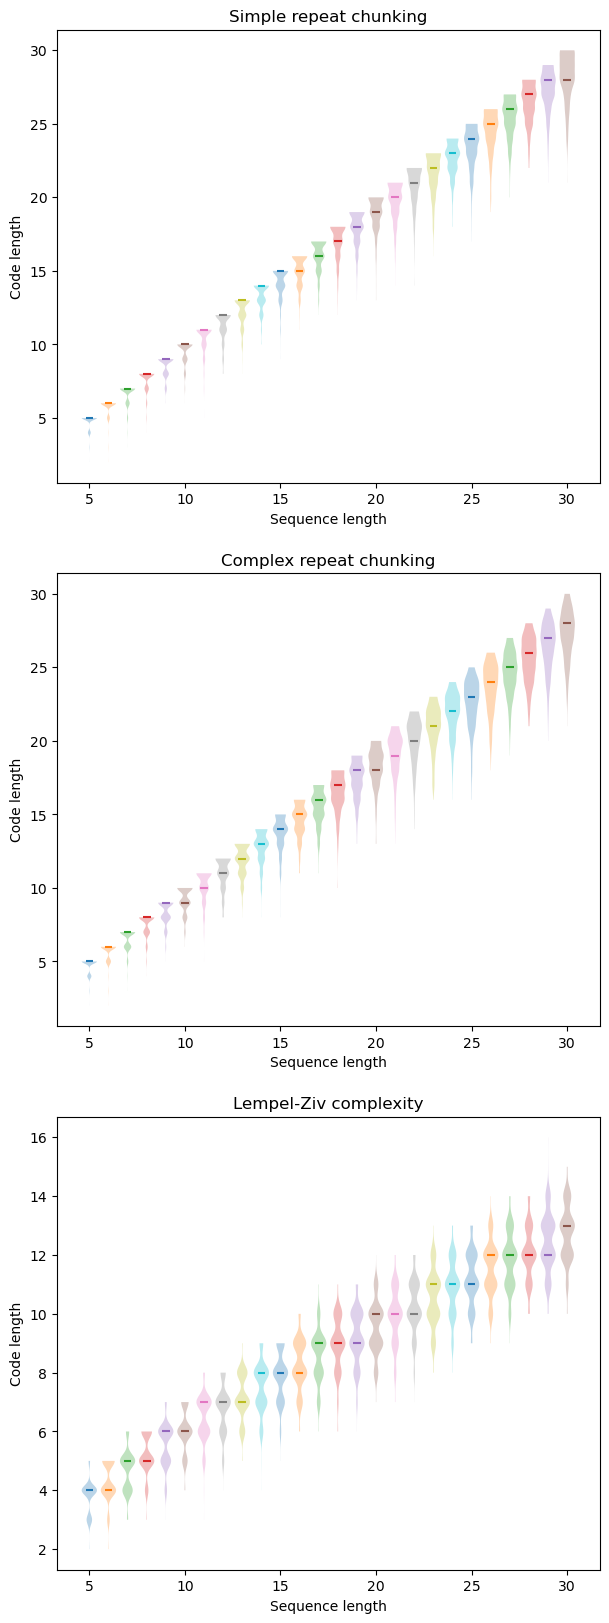

In [95]:
np.random.seed(128)
random_seqs = sample_random_sequences(30, 10000, min=5)
lengths = np.array([len(seq) for seq in random_seqs])

codelen1 = get_measure_multiple_seqs(simple_repeat_scheme, random_seqs, get_code_lengths)
codelen2 = get_measure_multiple_seqs(LZ_scheme, random_seqs, get_code_lengths)
codelen3 = get_measure_multiple_seqs(complex_repeat_scheme, random_seqs, get_code_lengths)

s = 8
a = 0.2
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].scatter(lengths, codelen1, alpha=a, s=s)
ax[1].scatter(lengths, codelen3, alpha=a, s=s)
ax[2].scatter(lengths, codelen2, alpha=a, s=s)
ax[0].set(xlabel='Sequence length', ylabel='Code length', title='Simple repeat chunking')
ax[1].set(xlabel='Sequence length', ylabel='Code length', title='Complex repeat chunking')
ax[2].set(xlabel='Sequence length', ylabel='Code length', title='Lempel-Ziv complexity')
fig.suptitle(f'Simulated random data')

unique_lens = np.unique(lengths)

fig, ax = plt.subplots(3, 1, figsize=(7, 20))
quantiles = []
for l in unique_lens:
    idx = np.where(lengths == l)
    ax[0].violinplot(codelen1[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)
    ax[1].violinplot(codelen3[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)
    ax[2].violinplot(codelen2[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)

ax[0].set(xlabel='Sequence length', ylabel='Code length', title='Simple repeat chunking')
ax[1].set(xlabel='Sequence length', ylabel='Code length', title='Complex repeat chunking')
ax[2].set(xlabel='Sequence length', ylabel='Code length', title='Lempel-Ziv complexity')

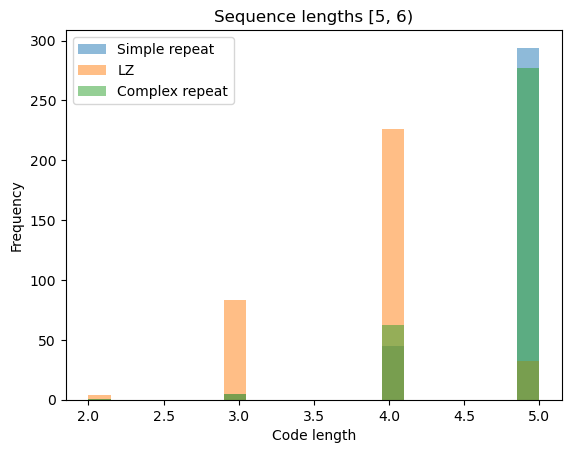

In [25]:
min_len = 5
max_len = 6
inds = np.where((np.array(lengths) >= min_len) & (np.array(lengths) < max_len))[0]

plt.hist(codelen1[inds], bins=20, alpha=0.5, label='Simple repeat')
plt.hist(codelen2[inds], bins=20, alpha=0.5, label='LZ')
plt.hist(codelen3[inds], bins=20, alpha=0.5, label='Complex repeat')
plt.xlabel('Code length')
plt.ylabel('Frequency')
plt.title(f'Sequence lengths [{min_len}, {max_len})')
plt.legend()

Text(0, 0.5, 'Chunkability')

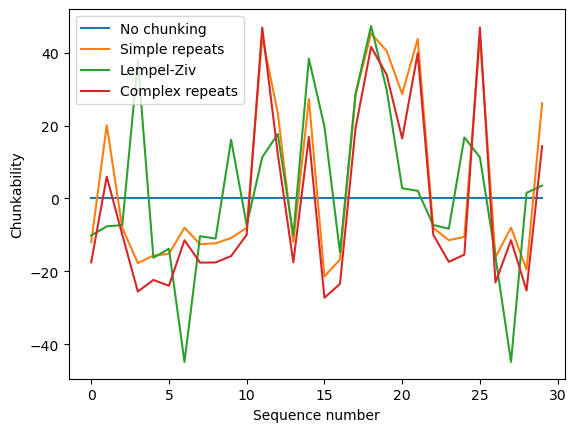

In [90]:
n = 30
np.random.seed(18)
inds = np.random.choice(np.arange(len(chunk1)), n)

plt.plot(np.arange(n), np.zeros(n), label='No chunking')
plt.plot(np.arange(n), np.array(chunk1)[inds], label='Simple repeats')
plt.plot(np.arange(n), np.array(chunk2)[inds], label='Lempel-Ziv')
plt.plot(np.arange(n), np.array(chunk3)[inds], label='Complex repeats')
plt.legend()
plt.xlabel('Sequence number')
plt.ylabel('Chunkability')

